In [1]:
from scipy.optimize import minimize
from Truss_2D import Truss_2D
import numpy as np
from random import random
import matplotlib.pyplot as plt 

### Step 1: Initialize Design Variables

In [2]:
area_old = 50

### Step 2.1: Define Model Analysis

In [3]:
def Truss_solver(cross_sectional_areas):
    nodes = {1: [720,360], 2:[720,0], 3:[360,360], 4:[360,0], 5:[0,360], 6:[0,0]}
    elements = {1:[5,3], 2:[3,1], 3:[6,4], 4:[4,2], 5:[3,4], 6:[1,2], 7:[5,4], 8:[6,3], 9:[3,2], 10:[4,1]}
    supports = {5:[1,1], 6:[1,1]}
    forces = {2:[0,-100], 4:[0,-100]}
    elasticity = {key: 10_000 for key in elements}
    cross_area = {1:cross_sectional_areas[0], 2:cross_sectional_areas[1], 3:cross_sectional_areas[2], 4:cross_sectional_areas[3], 5:cross_sectional_areas[4],
                  6:cross_sectional_areas[5], 7:cross_sectional_areas[6], 8:cross_sectional_areas[7], 9:cross_sectional_areas[8], 10:cross_sectional_areas[9]}

    Ten_Bar_Truss_Case_1 = Truss_2D(nodes = nodes,
                                    elements= elements,
                                    supports= supports,
                                    forces = forces,
                                    elasticity= elasticity,
                                    cross_area= cross_area)

    Ten_Bar_Truss_Case_1.Solve()

    return (Ten_Bar_Truss_Case_1.member_lengths_, Ten_Bar_Truss_Case_1.member_stresses_, Ten_Bar_Truss_Case_1.displacements_)

#### Step 2.2: Define Objective Function

In [4]:
def Objective_Function(areas):
    
    member_lengths, member_stresses, node_displacements = Truss_solver(areas)    
    total_area = np.array(areas)
    total_member_lengths = []
    
    for length in member_lengths:
        total_member_lengths.append(member_lengths[length])

    total_member_lengths = np.array(total_member_lengths)

    weight = total_area.dot(np.array(total_member_lengths))

    weight = weight.sum() * 0.1 # lb/in^3

    return (weight, member_stresses, node_displacements)

In [19]:
Objective_Function([100 for i in range(10)])

(41964.67529817257,
 {1: 1.95361,
  2: 0.40139,
  3: -2.04639,
  4: -0.59861,
  5: 0.35472,
  6: 0.40139,
  7: 1.47972,
  8: -1.34875,
  9: 0.84681,
  10: -0.56736},
 {1: [0.08478, -0.37951],
  2: [-0.09522, -0.39396],
  3: [0.07033, -0.16744],
  4: [-0.07367, -0.18021],
  5: [0.0, 0.0],
  6: [0.0, 0.0]})

#### Step 2.3: Define Constraints

In [5]:
Objective_Function([area_old for i in range(10)])

(20982.337649086287,
 {1: 3.90722,
  2: 0.8025,
  3: -4.09278,
  4: -1.1975,
  5: 0.70972,
  6: 0.80222,
  7: 2.95944,
  8: -2.69736,
  9: 1.69347,
  10: -1.135},
 {1: [0.16955, -0.75903],
  2: [-0.19045, -0.78791],
  3: [0.14066, -0.33487],
  4: [-0.14734, -0.36042],
  5: [0.0, 0.0],
  6: [0.0, 0.0]})

### Step 3: Define Algorithm

Step 3.1: Initialize Parameters

In [6]:
# intermediate variables 
k = 0.05 # move variable's constant
M = 500 # number of loops to be performed
T0 = 5000 # initial temperature
N = 20 # initial number of neighbors per search space loop
alpha = 0.85 # cooling parameter

In [7]:
temp = [] # storing of values for the temperature per loop M
min_weight = [] # storing best value of the objective function per loop M
area_list = [] # storing x values per loop for plotting purposes

Step 3.2: Simulated Annealing Algorithm

In [8]:
def Random_Number_Check(objective_old, objective_new, Init_temp):
    return 1/((np.exp(objective_old - objective_new)) / Init_temp)

In [38]:
%%time 
for m in range(M):
    for n in range(N):

        random_area = random()
        
        if random_area >= 0.5:
            area_new = k*random_area
        else:
            area_new = -k*random_area  

        area_new = area_old + area_new

        areas_new_array = [area_new for i in range(10)]
        areas_old_array = [area_old for i in range(10)]

        weight_computed, stresses_new, node_displacement_new = Objective_Function(areas_new_array)
        weight_old, _, _ = Objective_Function(areas_old_array)

        check = Random_Number_Check(weight_computed, weight_old, T0)
        random_number = random()

        # Contraint 1: stresses should be within 25ksi and -25ksi
        stress_counter = []
        
        for stress in range(1,len(stresses_new)+1):
            if stresses_new[stress] >= 25 or stresses_new[stress] <= -25:
                stress_counter.append(1)
            else:
                stress_counter.append(0)

        # Constraint 2: Node Displacement should be limited to -2in and 2in
        displacement_counter = []
        
        for displacement in range(1,len(node_displacement_new)+1):
            x = node_displacement_new[displacement][0]
            y = node_displacement_new[displacement][1]
            if x >= 2 or x <= -2:
                displacement_counter.append(1)
            elif y >= 2 or y <= -2:
                displacement_counter.append(1)
            else:
                displacement_counter.append(0)

        if sum(stress_counter) >= 1 or sum(displacement_counter) >=1:
            area_old = area_old
        else:        
            if weight_computed <= weight_old:
                area_old = area_new
            elif random_number <= check:
                area_old = area_new
            else:
                area_old = area_old

    temp.append(T0)
    min_weight.append(weight_old)
    area_list.append(area_old)
    
    T0 = alpha * T0

Wall time: 24.3 s


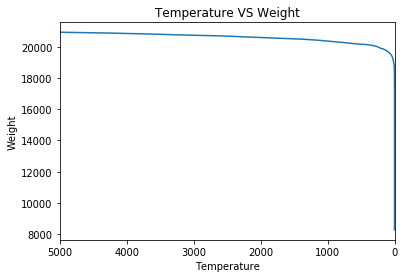

In [39]:
plt.xlim(5000,0)
plt.xlabel('Temperature')
plt.ylabel('Weight')
plt.title('Temperature VS Weight')
plt.plot(temp, min_weight)

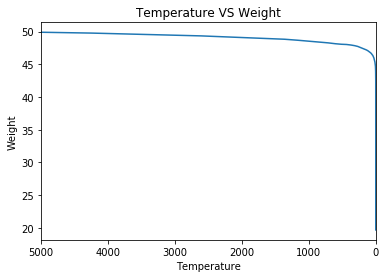

In [40]:
plt.xlim(5000,0)
plt.xlabel('Temperature')
plt.ylabel('Weight')
plt.title('Temperature VS Weight')
plt.plot(temp, area_list)

In [41]:
area_list[-1]

19.697924362075632

In [42]:
nodes = {1: [720,360], 2:[720,0], 3:[360,360], 4:[360,0], 5:[0,360], 6:[0,0]}
elements = {1:[5,3], 2:[3,1], 3:[6,4], 4:[4,2], 5:[3,4], 6:[1,2], 7:[5,4], 8:[6,3], 9:[3,2], 10:[4,1]}
supports = {5:[1,1], 6:[1,1]}
forces = {2:[0,-100], 4:[0,-100]}
elasticity = {key: 10_000 for key in elements}
cross_area = {key: area_list[-1] for key in range(1,11)}

Ten_Bar_Truss_Case_1 = Truss_2D(nodes = nodes,
                                elements= elements,
                                supports= supports,
                                forces = forces,
                                elasticity= elasticity,
                                cross_area= cross_area)

Ten_Bar_Truss_Case_1.Solve()

In [43]:
Ten_Bar_Truss_Case_1.displacements_

{1: [0.43038, -1.92666],
 2: [-0.48342, -1.99999],
 3: [0.35705, -0.85001],
 4: [-0.37399, -0.91488],
 5: [0.0, 0.0],
 6: [0.0, 0.0]}

In [44]:
Ten_Bar_Truss_Case_1.member_stresses_

{1: 9.91806,
 2: 2.03694,
 3: -10.38861,
 4: -3.03972,
 5: 1.80194,
 6: 2.03694,
 7: 7.51236,
 8: -6.84667,
 9: 4.29875,
 10: -2.88069}

In [45]:
weight, _, _ = Objective_Function([area_list[-1] for i in range(10)])
weight

8266.16999902467